# Laboratorio 6 Parte 2

En este laboratorio, estaremos repasando los conceptos de Generative Adversarial Networks En la segunda parte nos acercaremos a esta arquitectura a través de buscar generar numeros que parecieran ser generados a mano. Esta vez ya no usaremos versiones deprecadas de la librería de PyTorch, por ende, creen un nuevo virtual env con las librerías más recientes que puedan por favor.

Al igual que en laboratorios anteriores, para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
!pip install scikit-image
!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

     - 0 bytes ? 0:00:00
     | 119.1 kB 587.3 kB/s 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jhwutils: filename=jhwutils-1.3-py3-none-any.whl size=41859 sha256=9718c5d0b84fc3d656e63b2213ddea086174d8fdaee9d4b9230961dba2eeae58
  Stored in directory: C:\Users\JM\AppData\Local\Temp\pip-ephem-wheel-cache-pfd6m70g\wheels\2b\c0\bb\e488c0c509d2400eef5593a732c1c19a1170128cf068ee2d7d
Successfully built jhwutils
  Attempting uninstall: jhwutils
    Found existing installation: jhwutils 1.3
    Uninstalling jhwutils-1.3:
      Successfully uninstalled jhwutils-1.3
     - 0 bytes ? 0:00:00
     - 4.2 kB ? 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lautils: filename=lautils-1.0-py3-none-any.whl size=2832 sha256=1c5032923afae7960156c01111fd8f5ca905b496b21cfe2404303e86d4b6c03a
  Stored in directory: C:\Users\JM\AppData\Local\Tem

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [3]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [4]:
# carne_1 = 
# firma_mecanografiada_1 = 
# carne_2 = 
# firma_mecanografiada_2 = 
# YOUR CODE HERE

carne_1 = "22049"
firma_mecanografiada_1 = "Sofía Mishell Velásquez"
carne_2 = "22398"
firma_mecanografiada_2 = "José Rodrigo Marchena"

In [5]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

### Introducción

**Créditos:** Esta parte de este laboratorio está tomado y basado en uno de los blogs de Renato Candido, así como las imagenes presentadas en este laboratorio a menos que se indique lo contrario.
    
Las redes generativas adversarias también pueden generar muestras de alta dimensionalidad, como imágenes. En este ejemplo, se va a utilizar una GAN para generar imágenes de dígitos escritos a mano. Para ello, se entrenarán los modelos utilizando el conjunto de datos MNIST de dígitos escritos a mano, que está incluido en el paquete torchvision.

Dado que este ejemplo utiliza imágenes en el conjunto de datos de entrenamiento, los modelos necesitan ser más complejos, con un mayor número de parámetros. Esto hace que el proceso de entrenamiento sea más lento, llevando alrededor de dos minutos por época (aproximadamente) al ejecutarse en la CPU. Se necesitarán alrededor de cincuenta épocas para obtener un resultado relevante, por lo que el tiempo total de entrenamiento al usar una CPU es de alrededor de cien minutos.

Para reducir el tiempo de entrenamiento, se puede utilizar una GPU si está disponible. Sin embargo, será necesario mover manualmente tensores y modelos a la GPU para usarlos en el proceso de entrenamiento.

Se puede asegurar que el código se ejecutará en cualquier configuración creando un objeto de dispositivo que apunte a la CPU o, si está disponible, a la GPU. Más adelante, se utilizará este dispositivo para definir dónde deben crearse los tensores y los modelos, utilizando la GPU si está disponible.

In [38]:
!conda activate torch19

In [46]:
!pip install torchvision==0.10.1 --prefer-binary

^C


  Using cached torch-1.9.1-cp38-cp38-win_amd64.whl.metadata (25 kB)
Using cached torch-1.9.1-cp38-cp38-win_amd64.whl (222.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.


In [47]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
    
import random
import numpy as np


In [48]:
seed_ = 111

def seed_all(seed_):
    random.seed(seed_)
    np.random.seed(seed_)
    torch.manual_seed(seed_)
    torch.cuda.manual_seed(seed_)
    torch.backends.cudnn.deterministic = True

seed_all(seed_)

In [49]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


### Preparando la Data

El conjunto de datos MNIST consta de imágenes en escala de grises de 28 × 28 píxeles de dígitos escritos a mano del 0 al 9. Para usarlos con PyTorch, será necesario realizar algunas conversiones. Para ello, se define transform, una función que se utilizará al cargar los datos:

La función tiene dos partes:

* transforms.ToTensor() convierte los datos en un tensor de PyTorch.
* transforms.Normalize() convierte el rango de los coeficientes del tensor.

Los coeficientes originales proporcionados por transforms.ToTensor() varían de 0 a 1, y dado que los fondos de las imágenes son negros, la mayoría de los coeficientes son iguales a 0 cuando se representan utilizando este rango.

transforms.Normalize() cambia el rango de los coeficientes a -1 a 1 restando 0.5 de los coeficientes originales y dividiendo el resultado por 0.5. Con esta transformación, el número de elementos iguales a 0 en las muestras de entrada se reduce drásticamente, lo que ayuda en el entrenamiento de los modelos.

Los argumentos de transforms.Normalize() son dos tuplas, (M₁, ..., Mₙ) y (S₁, ..., Sₙ), donde n representa el número de canales de las imágenes. Las imágenes en escala de grises como las del conjunto de datos MNIST tienen solo un canal, por lo que las tuplas tienen solo un valor. Luego, para cada canal i de la imagen, transforms.Normalize() resta Mᵢ de los coeficientes y divide el resultado por Sᵢ.

Luego se pueden cargar los datos de entrenamiento utilizando torchvision.datasets.MNIST y realizar las conversiones utilizando transform

El argumento download=True garantiza que la primera vez que se ejecute el código, el conjunto de datos MNIST se descargará y almacenará en el directorio actual, como se indica en el argumento root.

Después que se ha creado train_set, se puede crear el cargador de datos como se hizo antes en la parte 1. 

Cabe decir que se puede utilizar Matplotlib para trazar algunas muestras de los datos de entrenamiento. Para mejorar la visualización, se puede usar cmap=gray_r para invertir el mapa de colores y representar los dígitos en negro sobre un fondo blanco:

Como se puede ver más adelante, hay dígitos con diferentes estilos de escritura. A medida que la GAN aprende la distribución de los datos, también generará dígitos con diferentes estilos de escritura.


In [79]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [51]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



9913344it [00:01, 6445805.68it/s]                             


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



29696it [00:00, 527757.99it/s]           


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



1649664it [00:00, 3536889.57it/s]                             


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



5120it [00:00, 1025247.61it/s]          

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw




c:\Users\JM\miniconda3\envs\torch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [82]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
)

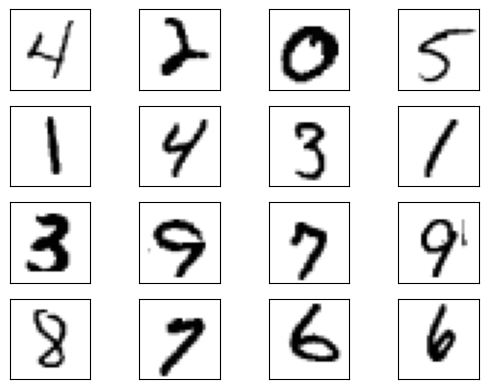

In [83]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Implementando el Discriminador y el Generador

En este caso, el discriminador es una red neuronal MLP (multi-layer perceptron) que recibe una imagen de 28 × 28 píxeles y proporciona la probabilidad de que la imagen pertenezca a los datos reales de entrenamiento.

Para introducir los coeficientes de la imagen en la red neuronal MLP, se vectorizan para que la red neuronal reciba vectores con 784 coeficientes.

La vectorización ocurre cuando se ejecuta .forward(), ya que la llamada a x.view() convierte la forma del tensor de entrada. En este caso, la forma original de la entrada "x" es 32 × 1 × 28 × 28, donde 32 es el tamaño del batch que se ha configurado. Después de la conversión, la forma de "x" se convierte en 32 × 784, con cada línea representando los coeficientes de una imagen del conjunto de entrenamiento.

Para ejecutar el modelo de discriminador usando la GPU, hay que instanciarlo y enviarlo a la GPU con .to(). Para usar una GPU cuando haya una disponible, se puede enviar el modelo al objeto de dispositivo creado anteriormente.

Dado que el generador va a generar datos más complejos, es necesario aumentar las dimensiones de la entrada desde el espacio latente. En este caso, el generador va a recibir una entrada de 100 dimensiones y proporcionará una salida con 784 coeficientes, que se organizarán en un tensor de 28 × 28 que representa una imagen.

Luego, se utiliza la función tangente hiperbólica Tanh() como activación de la capa de salida, ya que los coeficientes de salida deben estar en el intervalo de -1 a 1 (por la normalización que se hizo anteriormente). Después, se instancia el generador y se envía a device para usar la GPU si está disponible.


In [84]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Aprox 11 lineas
            # lineal de la entrada dicha y salida 1024
            # ReLU
            # Dropout de 30%
            # Lineal de la entrada correspondiente y salida 512
            # ReLU
            # Dropout de 30%
            # Lienal de la entrada correspondiente y salida 256
            # ReLU
            # Dropout de 30%
            # Lineal de la entrada correspondiente y salida 1
            # Sigmoide
            # YOUR CODE HERE
            nn.Linear(in_features=784, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [85]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Aprox 8 lienas para
            # Lineal input = 100, output = 256
            # ReLU
            # Lineal output = 512
            # ReLU
            # Lineal output = 1024
            # ReLU
            # Lineal output = 784
            # Tanh
            # YOUR CODE HERE
            
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

### Entrenando los Modelos

Para entrenar los modelos, es necesario definir los parámetros de entrenamiento y los optimizadores como se hizo en la parte anterior.

Para obtener un mejor resultado, se disminuye la tasa de aprendizaje de la primera parte. También se establece el número de épocas en 10 para reducir el tiempo de entrenamiento.

El ciclo de entrenamiento es muy similar al que se usó en la parte previa. Note como se envían los datos de entrenamiento a device para usar la GPU si está disponible

Algunos de los tensores no necesitan ser enviados explícitamente a la GPU con device. Este es el caso de generated_samples, que ya se envió a una GPU disponible, ya que latent_space_samples y generator se enviaron a la GPU previamente.

Dado que esta parte presenta modelos más complejos, el entrenamiento puede llevar un poco más de tiempo. Después de que termine, se pueden verificar los resultados generando algunas muestras de dígitos escritos a mano.

In [86]:
list_images = []

# Aprox 1 linea para que decidan donde guardar un set de imagen que vamos a generar de las graficas
# path_imgs =
# YOUR CODE HERE

path_imgs = './part2_generated/'
seed_all(seed_)

discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        # Aprox 2 lineas para
        # setear el discriminador en zero_grad
        # output_discriminator =
        # YOUR CODE HERE
        
        discriminator.zero_grad()
        output_discriminator = discriminator.forward(all_samples)
        
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        # Aprox dos lineas para
        # llamar al paso backward sobre el loss_discriminator
        # llamar al optimizador sobre optimizer_discriminator
        # YOUR CODE HERE
        
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )

        # Training the generator
        # Training the generator
        # Aprox 2 lineas para
        # setear el generador en zero_grad
        # output_discriminator =
        # YOUR CODE HERE
        
        generator.zero_grad()
        output_discriminator = discriminator(real_samples)
        
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        
        # Aprox dos lineas para
        # llamar al paso backward sobre el loss_generator
        # llamar al optimizador sobre optimizer_generator
        # YOUR CODE HERE
        
        loss_generator.backward()
        optimizer_generator.step()
        
        # Guardamos las imagenes
        if epoch % 2 == 0 and n ==  batch_size - 1:
            generated_samples_detached = generated_samples.cpu().detach()
            for i in range(16):
                ax = plt.subplot(4, 4, i + 1)
                plt.imshow(generated_samples_detached[i].reshape(28, 28), cmap="gray_r")
                plt.xticks([])
                plt.yticks([])
                plt.title("Epoch "+str(epoch))
            name = path_imgs + "epoch_mnist"+str(epoch)+".jpg"
            plt.savefig(name, format="jpg")
            plt.close()
            list_images.append(name)

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5500081777572632
Epoch: 0 Loss G.: 0.5083334445953369
Epoch: 1 Loss D.: 0.055140912532806396
Epoch: 1 Loss G.: 5.820478439331055
Epoch: 2 Loss D.: 0.006840161047875881
Epoch: 2 Loss G.: 6.689520835876465
Epoch: 3 Loss D.: 0.030281735584139824
Epoch: 3 Loss G.: 7.272030353546143
Epoch: 4 Loss D.: 0.005476341117173433
Epoch: 4 Loss G.: 6.355573654174805
Epoch: 5 Loss D.: 0.09016230702400208
Epoch: 5 Loss G.: 3.6505932807922363
Epoch: 6 Loss D.: 0.06101204827427864
Epoch: 6 Loss G.: 3.909489393234253
Epoch: 7 Loss D.: 0.3515963852405548
Epoch: 7 Loss G.: 2.69246244430542
Epoch: 8 Loss D.: 0.14520946145057678
Epoch: 8 Loss G.: 1.9525721073150635
Epoch: 9 Loss D.: 0.2860259413719177
Epoch: 9 Loss G.: 1.9065567255020142
Epoch: 10 Loss D.: 0.3367772102355957
Epoch: 10 Loss G.: 1.8433457612991333
Epoch: 11 Loss D.: 0.3454165756702423
Epoch: 11 Loss G.: 1.991652011871338
Epoch: 12 Loss D.: 0.4450780153274536
Epoch: 12 Loss G.: 1.8870501518249512
Epoch: 13 Loss D.: 0.40766215

In [88]:
torch.save(discriminator, "discriminator.pt")
torch.save(generator, "generator.pt")

In [91]:
with tick.marks(35):        
    assert compare_numbers(new_representation(loss_discriminator), "3c3d", '0x1.3333333333333p-1')
    
with tick.marks(35):        
    assert compare_numbers(new_representation(loss_generator), "3c3d", '0x1.8000000000000p+0')

### Validación del Resultado

Para generar dígitos escritos a mano, es necesario tomar algunas muestras aleatorias del espacio latente y alimentarlas al generador.

Para trazar generated_samples, es necesario mover los datos de vuelta a la CPU en caso de que estén en la GPU. Para ello, simplemente se puede llamar a .cpu(). Como se hizo anteriormente, también es necesario llamar a .detach() antes de usar Matplotlib para trazar los datos.

La salida debería ser dígitos que se asemejen a los datos de entrenamiento. Después de cincuenta épocas de entrenamiento, hay varios dígitos generados que se asemejan a los reales. Se pueden mejorar los resultados considerando más épocas de entrenamiento. Al igual que en la parte anterior, al utilizar un tensor de muestras de espacio latente fijo y alimentarlo al generador al final de cada época durante el proceso de entrenamiento, se puede visualizar la evolución del entrenamiento.

Se puede observar que al comienzo del proceso de entrenamiento, las imágenes generadas son completamente aleatorias. A medida que avanza el entrenamiento, el generador aprende la distribución de los datos reales y, a algunas épocas, algunos dígitos generados ya se asemejan a los datos reales.

In [92]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

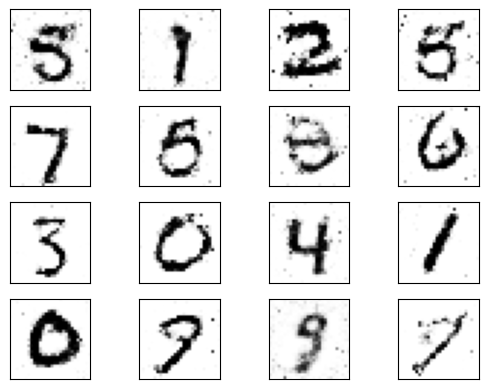

In [93]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

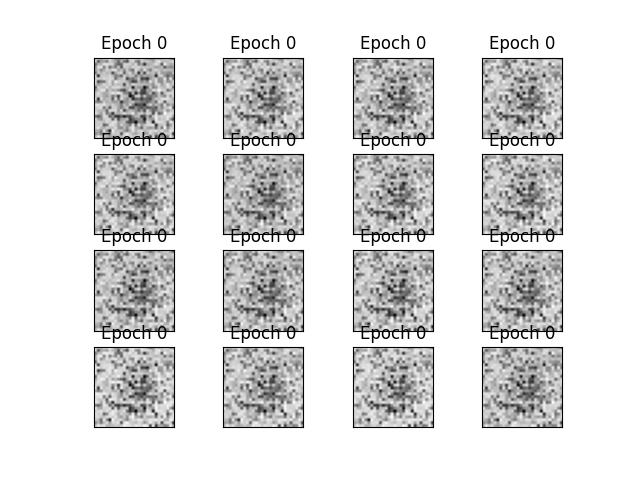

In [94]:
# Visualización del progreso de entrenamiento
# Para que esto se ve bien, por favor reinicien el kernel y corran todo el notebook

from PIL import Image
from IPython.display import display, Image as IPImage

images = [Image.open(path) for path in list_images]

# Save the images as an animated GIF
gif_path = "animation.gif"  # Specify the path for the GIF file
images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=1000)
display(IPImage(filename=gif_path))

*Las respuestas de estas preguntas representan el 30% de este notebook*

**PREGUNTAS:**
* ¿Qué diferencias hay entre los modelos usados en la primera parte y los usados en esta parte?
* ¿Qué tan bien se han creado las imagenes esperadas?
* ¿Cómo mejoraría los modelos?
* Observe el GIF creado, y describa la evolución que va viendo al pasar de las epocas

In [95]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 


La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
